In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os    
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize


In [10]:
print(os.listdir("./input/chest_xray/chest_xray"))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [11]:
print(os.listdir("./input/chest_xray/chest_xray/train/"))

['NORMAL', 'PNEUMONIA']


In [2]:
TRAIN_DIR = "./input/chest_xray/chest_xray/train/"
TEST_DIR =  "./input/chest_xray/chest_xray/test/"
VAL_DIR = "./input/chest_xray/chest_xray/val/"

In [3]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                   
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [15]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 3875/3875 [13:09<00:00,  4.91it/s]


In [56]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 390/390 [00:48<00:00,  7.97it/s]


In [4]:
X_val , y_val = get_data(VAL_DIR)

100%|██████████| 9/9 [00:01<00:00,  7.82it/s]


In [19]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [20]:
print(y_train.shape,'\n',y_test.shape)

(5216,) 
 (624,)


In [21]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [22]:
print(y_train.shape,'\n',y_test.shape)

(5216, 2) 
 (624, 2)


In [16]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


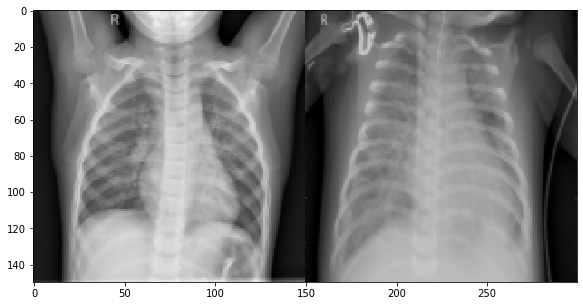

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


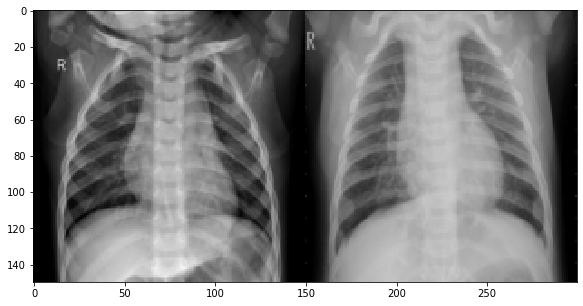

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


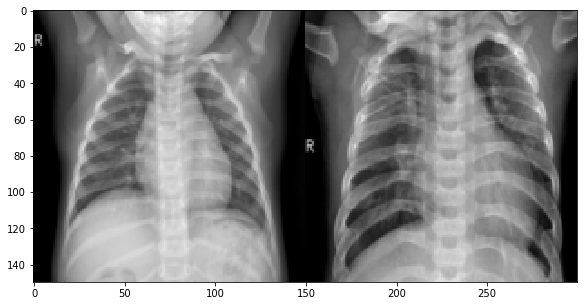

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


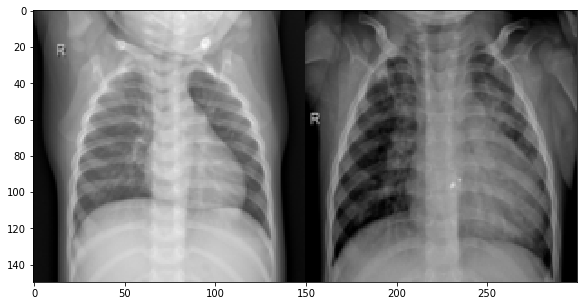

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


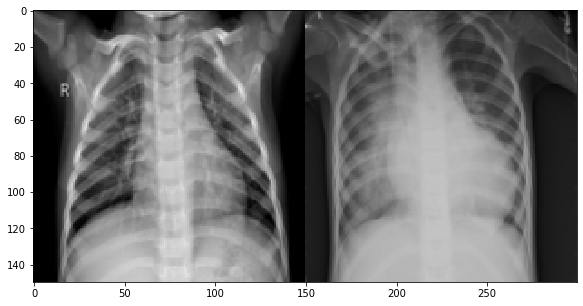

In [17]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

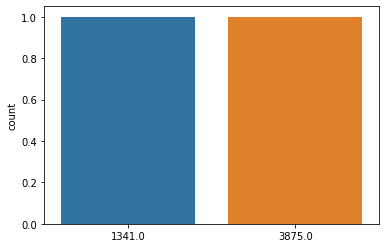

In [25]:
import seaborn as sns
count = y_train.sum(axis = 0)
sns.countplot(x = count)

In [18]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

C:\Users\Navin Stark\anaconda3\envs\dl\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [19]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [5]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.common.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [26]:
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [6]:
from keras.utils import get_custom_objects

def swish_activation(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish_activation': Activation(swish_activation)})

In [42]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [43]:
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

In [44]:
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding ='same'))


In [45]:
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding ='same'))

In [46]:
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding ='same'))


In [47]:
model.add(Flatten())

In [48]:
model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

In [49]:
model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

In [50]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 3, 150, 16)        21616     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 150, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 75, 16)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 75, 32)         4640      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 75, 32)         9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 38, 32)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 38, 64)        

In [51]:
batch_size = 256
epochs = 6

In [43]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/6
5216/5216 [==============================] - 148s 28ms/step - loss: 0.5936 - accuracy: 0.7411 - val_loss: 0.6699 - val_accuracy: 0.6250
Epoch 2/6


C:\Users\Navin Stark\anaconda3\envs\dl\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\Navin Stark\anaconda3\envs\dl\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


5216/5216 [==============================] - 40s 8ms/step - loss: 0.5391 - accuracy: 0.7429 - val_loss: 0.6109 - val_accuracy: 0.6250
Epoch 3/6
5216/5216 [==============================] - 39s 8ms/step - loss: 0.4209 - accuracy: 0.7682 - val_loss: 0.4900 - val_accuracy: 0.7147
Epoch 4/6
5216/5216 [==============================] - 40s 8ms/step - loss: 0.3490 - accuracy: 0.8452 - val_loss: 0.4338 - val_accuracy: 0.8125
Epoch 5/6
5216/5216 [==============================] - 59s 11ms/step - loss: 0.3109 - accuracy: 0.8821 - val_loss: 0.5577 - val_accuracy: 0.7644
Epoch 6/6
5216/5216 [==============================] - 39s 8ms/step - loss: 0.2678 - accuracy: 0.8961 - val_loss: 0.4853 - val_accuracy: 0.7981


In [44]:
import matplotlib.pyplot as plt



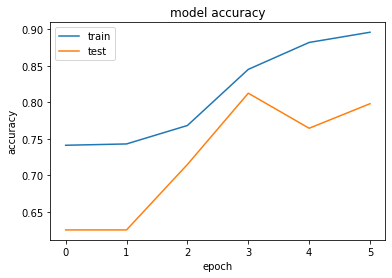

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

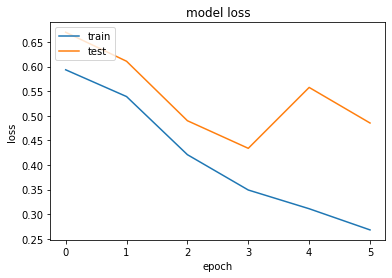

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

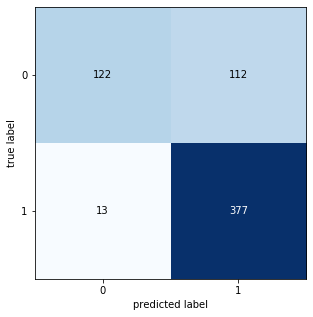

In [49]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [2]:
377 / (377 + 112)

0.7709611451942741

In [1]:
374 / (374 + 13)

0.9664082687338501

In [3]:
2*0.9664*0.77096 / (0.9664 + 0.77096)

0.8576872312013629

In [52]:
model.save("./saved_pnemonia_conv.h5")
print("Model Saved")

Model Saved


In [8]:
import cv2
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 150,150, 3
classifier = load_model('./saved_pnemonia_conv.h5')
color = True 
scale = 2

def draw_test(name, res, input_im, scale, img_row, img_height):
    BLACK = [0,0,0]
    res = int(res)
    if res == 0:
        pred = "NORMAL"
    if res == 1:
        pred = "PNEUMONIA"
   
        
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0]*2 ,cv2.BORDER_CONSTANT,value=BLACK)
    if color == False:
        expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, str(pred), (300, 80) , cv2.FONT_HERSHEY_COMPLEX_SMALL,1, (0,255, 0), 1)
   
    
    cv2.imshow(name, expanded_image)


for i in range(0,10):
    rand = np.random.randint(0,len(X_val))
    input_im = X_val[rand]
    imageL = cv2.resize(input_im, None, fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC) 
    input_im = input_im.reshape(1, img_depth, img_row, img_height) 
    
    ## Get Prediction
    res = str(classifier.predict_classes(input_im, 1, verbose = 0)[0])
              
    draw_test("Prediction", res, imageL, scale, img_row, img_height) 
    cv2.waitKey(0)

cv2.destroyAllWindows()